# Exploring DOA Techniques

In [1]:
import numpy as np
from numpy import linalg as lin
import scipy.signal as signal
from scipy import optimize,constants
import matplotlib.pyplot as plt

import ofdmradar
from ofdmradar import doa
from ofdmradar.doa import SingleToneReceiverArray, angle_from_omega, omega_from_angle

%matplotlib inline

plt.rc("figure", figsize=(15, 5))

First, we explore the native, trigonometric approach:

In [2]:
f_c = 2.45e9
lmb = constants.c/f_c
f_s = 1e6
ppm = 0
receivers = 4
delta_x = lmb/2
SNR=0

In [3]:
receiver = SingleToneReceiverArray(f_c, ppm, f_s, receivers, delta_x, SNR)

In [4]:
def plot_r(alpha):
    s = receiver.get_phasors(alpha)
    plt.figure(figsize=(10, 10))
    t = np.linspace(0, 2*np.pi, 1024)
    plt.plot(np.sin(t), np.cos(t))
    plt.plot(np.real(s), np.imag(s), "ro")
    plt.xlim((-1.5, 1.5))
    plt.ylim((-1.5, 1.5))
    plt.show()

In [5]:
angle = 10 / 180 * np.pi # np.pi/4 * np.random.randn()

In [6]:
N = 4096

In [7]:
r = receiver.receive(angle, N)

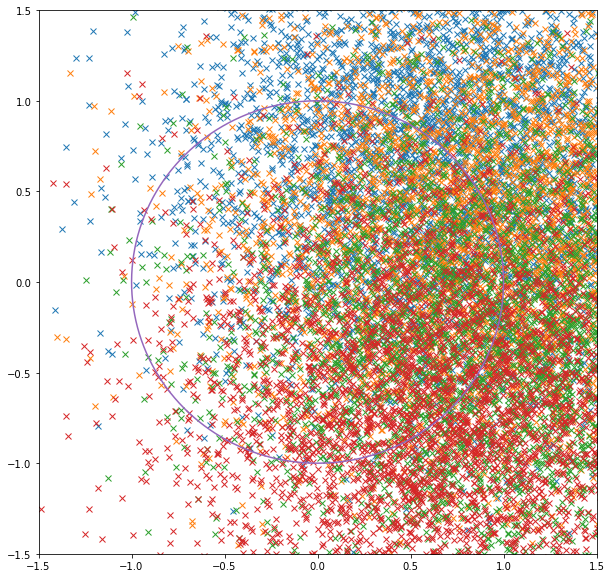

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(np.real(r.T), np.imag(r.T), "x");
t = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.sin(t), np.cos(t));
plt.ylim((-1.5, 1.5))
plt.xlim((-1.5, 1.5));

In [9]:
fft_size = 1024
fft_x = np.linspace(-90, 90, fft_size)

In [10]:
delta_phi = np.angle(np.mean(r[1:] * np.conj(r[:-1])))
delta_y = -delta_phi / (2 * np.pi) * lmb
delta_y
angle_estimate = np.arcsin(delta_y / delta_x)
print(f"Angle estimation: {angle_estimate*180/np.pi:.3f}°, true angle: {angle/np.pi*180:.3f}, error: {np.abs(angle_estimate-angle)*180/np.pi:.3e}°, SNR: {SNR} dB")

Angle estimation: 9.639°, true angle: 10.000, error: 3.614e-01°, SNR: 0 dB


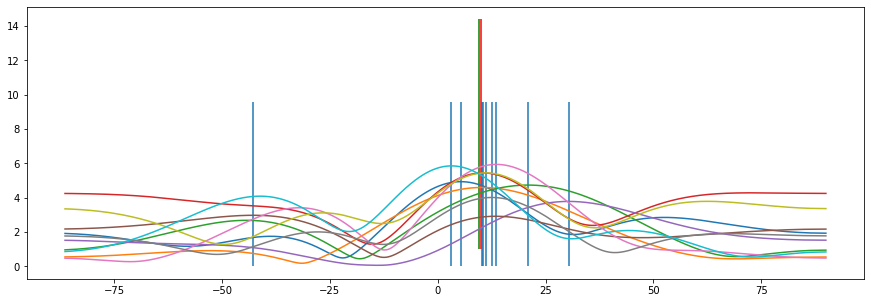

In [11]:
spec = np.fft.fftshift(np.abs(np.fft.fft(r, fft_size, axis=0)))
spec_x = np.linspace(-np.pi, np.pi, fft_size, endpoint=False)
delta_y = -spec_x / (2*np.pi) * lmb
angles = np.arcsin(delta_y / delta_x) * 180 / np.pi
plt.plot(angles, spec[:,:10])
plt.vlines(angle_estimate * 180 / np.pi, 1, np.max(spec)*1.5, "g");
plt.vlines(angle * 180 / np.pi, 1, np.max(spec)*1.5, "r");
peaks = angles[np.argmax(spec, axis=0)]
plt.vlines(peaks[:10], 0, np.max(spec));

In [12]:
est_sigma = np.sqrt(np.var(peaks))
est_mean = np.mean(peaks)
print(f"Mean: {est_mean:.3f}°, stddev: {est_sigma:.3e}")

Mean: 7.750°, stddev: 2.063e+01


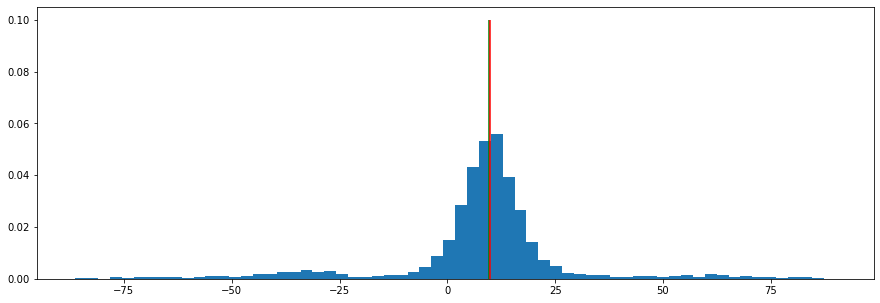

In [13]:
plt.hist(peaks, bins=64, density=True);
plt.vlines(angle_estimate * 180 / np.pi, 0, 0.1, "g");
plt.vlines(angle * 180 / np.pi, 0, 0.1, "r");

# MUSIC

In [14]:
R_x = r @ np.conj(r.T) / N

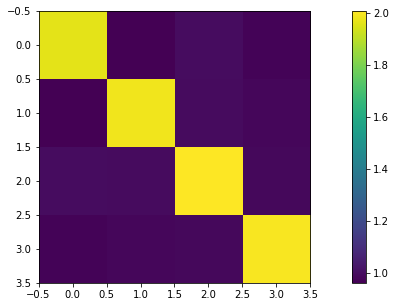

In [15]:
plt.imshow(np.abs(R_x))
plt.colorbar();

In [16]:
R_x.real

array([[ 1.96532049,  0.84534035,  0.48219816, -0.05139403],
       [ 0.84534035,  1.98418682,  0.85141679,  0.43639517],
       [ 0.48219816,  0.85141679,  2.00781505,  0.84523907],
       [-0.05139403,  0.43639517,  0.84523907,  1.99692504]])

In [17]:
assert np.allclose(R_x, np.conj(R_x).T)

In [18]:
lin.cond(R_x)

5.07416161361829

In [19]:
vals, vecs = lin.eigh(R_x)

In [20]:
p = 1 # Looking for a single source

In [21]:
s_i = []
n_i = []
i = 0
for k,v in sorted(enumerate(np.abs(vals)), key=lambda x: x[1], reverse=True):
    if i < p:
        s_i.append(k)
    else:
        n_i.append(k)
        
    i += 1

svals, svecs = vals[s_i], vecs[:,s_i] # Signal Space
nvals, nvecs = vals[n_i], vecs[:,n_i] # Noise Space

In [22]:
np.abs(svals)

array([4.93400974])

In [23]:
M = receivers

def P_MU(omega):
    e = np.exp(1j * omega * np.arange(M))
    # return 1 / np.sum(np.abs(np.conj(e.T) @ nvecs.T)**2)
    res = 1 / (np.conj(e) @ nvecs @ np.conj(nvecs.T) @ e)
    assert np.prod(np.array(res.shape)) == 1
    return np.sum(res)

In [24]:
omegas = np.linspace(-np.pi, np.pi, fft_size, endpoint=False)

music_pspec = np.array([P_MU(omega) for omega in omegas])

In [25]:
np.abs(svals)

array([4.93400974])

In [26]:
pspec = np.abs(music_pspec) / np.max(np.abs(music_pspec))

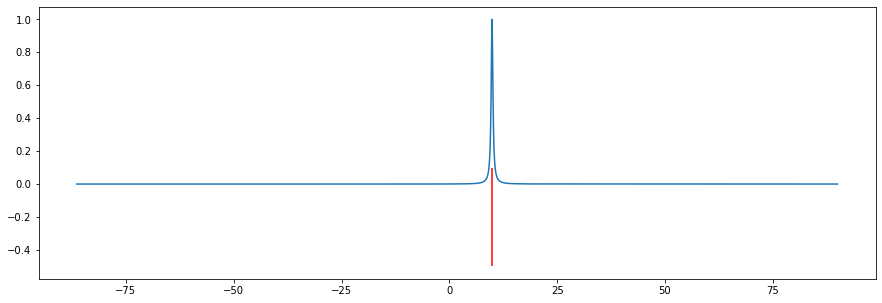

In [27]:
plt.plot(angles, pspec)
plt.vlines(angle * 180 / np.pi, -0.5, .1, "r");

In [28]:
angle * 180 / np.pi

10.0

In [29]:
angles[np.argmax(pspec)]

9.896853442815873

# ESPRIT

$$
\begin{align}
S_1 &= \left[I_{m-1} ~ 0 \right] S \\
S_2 &= \left[0 ~ I_{m-1} \right] S
\end{align}
$$

In [30]:
esprit_angle_estimate = doa.esprit(r, p)
print(f"ESPRIT DOA angle estimation: {esprit_angle_estimate[0]*180/np.pi:.3f}°, true angle: {angle/np.pi*180:.3f}, error: {np.abs(esprit_angle_estimate[0]-angle)*180/np.pi:.3e}°, SNR: {SNR} dB")

ESPRIT DOA angle estimation: 9.873°, true angle: 10.000, error: 1.274e-01°, SNR: 0 dB


In [31]:
esprit_angle_estimate

array([0.17230866])

# Array Calibration

In [32]:
receiver_uc = SingleToneReceiverArray(f_c, ppm, f_s, receivers, delta_x, SNR+10, calibrated=False)

In [33]:
r_uc = receiver_uc.receive(0, N)

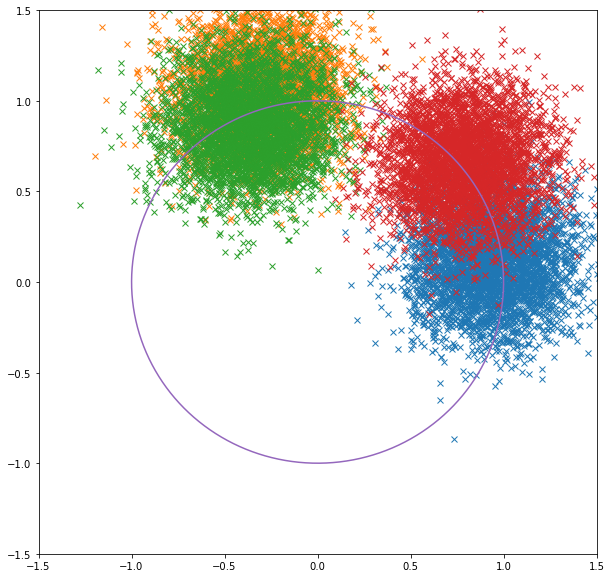

In [34]:
plt.figure(figsize=(10, 10))
plt.plot(np.real(r_uc.T), np.imag(r_uc.T), "x");
t = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.sin(t), np.cos(t));
plt.ylim((-1.5, 1.5))
plt.xlim((-1.5, 1.5));

In [35]:
Gamma_e = doa.estimate_gamma(receiver_uc.receive(0, N), receiver_uc, p, receivers, 0)
print(np.angle(Gamma_e))
print(np.abs(Gamma_e))

[0.         1.74597865 1.84343215 0.57259388]
[0.47392017 0.54535614 0.46800046 0.508883  ]


In [36]:
r_uc = receiver_uc.receive(angle, N)

In [37]:
r_corrected = 0.5 * r_uc / Gamma_e[:,np.newaxis]

In [38]:
tmp = 1/(2 * Gamma_e[:,np.newaxis])
cal = tmp * tmp.T.conj()

In [39]:
doa.esprit(r_uc, p, cal)

array([0.17567782])

In [40]:
doa.esprit(r_corrected, p, receivers)

array([0.17567782])

In [41]:
angle

0.17453292519943295

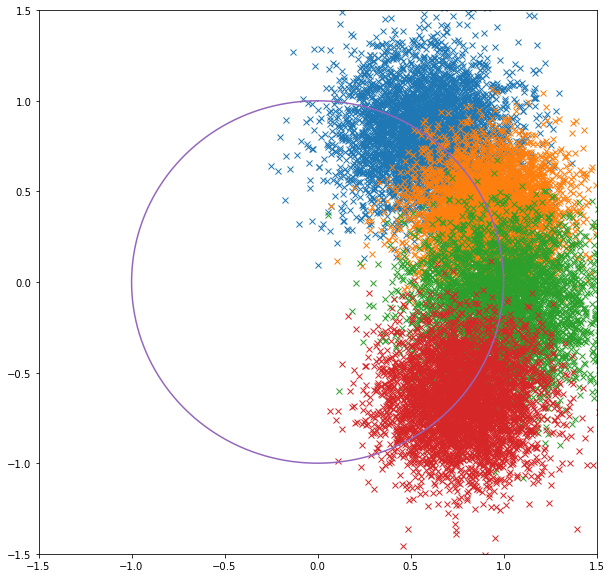

In [42]:
plt.figure(figsize=(10, 10))
plt.plot(np.real(r_corrected.T), np.imag(r_corrected.T), "x");
t = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.sin(t), np.cos(t));
plt.ylim((-1.5, 1.5))
plt.xlim((-1.5, 1.5));

In [43]:
np.angle(receiver_uc.Gamma)

array([0.12653239, 1.86433896, 1.96777842, 0.69539408])

In [44]:
np.abs(0.5 * receiver_uc.Gamma / Gamma_e)

array([1.00193   , 0.99968866, 1.0089792 , 1.00960197])

# M-ESPRIT (WIP)

In [45]:
def m_esprit(r, rx, n, m):
    """
    r: Receive signal, [m x s]
    n: Targets
    m: Array size
    """
    
    phi_e = 0.1
    Gamma_e = np.ones(m)
    ests = [phi_e]
    
    for i in range(20):
        phi_e = doa.esprit(r * Gamma_e[:,np.newaxis].conj(), n, m)
        ests.append(phi_e)
        Gamma_e = doa.estimate_gamma(r, rx, n, m, phi_e)
    
    return ests

In [46]:
m_esprit(r_uc, receiver_uc, p, receivers)

[0.1,
 array([0.11996002]),
 array([0.11996081]),
 array([0.11996159]),
 array([0.11996238]),
 array([0.11996316]),
 array([0.11996395]),
 array([0.11996473]),
 array([0.11996552]),
 array([0.1199663]),
 array([0.11996708]),
 array([0.11996787]),
 array([0.11996865]),
 array([0.11996944]),
 array([0.11997022]),
 array([0.11997101]),
 array([0.11997179]),
 array([0.11997258]),
 array([0.11997336]),
 array([0.11997415]),
 array([0.11997493])]

In [47]:
angle

0.17453292519943295